In [1]:
# Standard library imports
import os
import sys
import time
from matplotlib.colors import SymLogNorm
from itertools import combinations
from matplotlib.colors import LogNorm
from scipy.ndimage import gaussian_filter
# Numerical and Scientific Libraries
import numpy as np
from scipy import signal, linalg
from scipy.interpolate import splrep, BSpline
from scipy.stats import loguniform
from scipy.ndimage import convolve
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization.wcsaxes import WCSAxes

# Astropy Modules
from astropy.io import fits
from astropy.coordinates import SkyCoord, Angle
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.stats import sigma_clipped_stats
from astropy.time import Time
from astropy import constants, cosmology, units as u

# Photutils Modules
from photutils.segmentation import make_2dgaussian_kernel, detect_sources, deblend_sources
from photutils.background import Background2D, MedianBackground, SExtractorBackground

# Machine Learning and Gaussian Processes
from sklearn.gaussian_process import kernels, GaussianProcessRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.kernel_ridge import KernelRidge
import GPy
import emcee

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display, HTML

# LAL Modules
from lal import gpstime

# NFFT for Fourier Transforms
import nfft

# Astropy Cosmology
from astropy.cosmology import Planck18, FlatLambdaCDM

# Plotting configuration
mpl.rcParams.update({
    'text.usetex': True,
    'xtick.major.size': 8,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.minor.size': 4,
    'xtick.major.width': 1.5,
    'xtick.minor.width': 1.3,
    'ytick.major.size': 8,
    'ytick.minor.size': 4,
    'ytick.major.width': 1.5,
    'ytick.minor.width': 1.3,
    'patch.linewidth': 1.3,
    'axes.linewidth': 2
})

# Set environment variables
os.environ["OMP_NUM_THREADS"] = "1"

# Display settings for Jupyter Notebooks
display(HTML("<style>.container { width:100% !important; }</style>"))

# Add custom module paths
sys.path.insert(1, '../../milestone2/bispec_phase/scripts/notebooks/')


 /tmp/ipykernel_2109150/2166923077.py:47: UserWarning:Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal



In [2]:
data_path = '/media/himanshu/MyHDD/data_galaxy_evolution/process_data/'  # path to HST-JWST fits images

In [3]:
Control_ = fits.open(data_path+'Control_data_final.fits')
EELGs_   = fits.open(data_path+'EELGs_data_final.fits') # these fits include everything related to the control, eelgs samples

# see headers and extension-name for the data type

In [4]:
len(Control_), len(EELGs_) # total data arrays

(82, 36)

In [5]:
for i in range(len(EELGs_)):
    print(EELGs_[i].header['Extname'])

F814-original
F336-original
F814-segments
F814
F336
F814-background
F336-background
F814-weights
F336-weights
WCS-sourceID-20366
WCS-sourceID-11462
WCS-sourceID-12533
WCS-sourceID-17342
WCS-sourceID-18742
WCS-sourceID-15097
WCS-sourceID-15992
WCS-sourceID-18053
WCS-sourceID-19437
WCS-sourceID-19843
WCS-sourceID-19863
WCS-sourceID-20011
WCS-sourceID-20257
WCS-sourceID-21143
WCS-sourceID-21896
WCS-sourceID-22136
WCS-sourceID-22731
WCS-sourceID-10936
WCS-sourceID-13203
WCS-sourceID-11999
WCS-sourceID-12030
WCS-sourceID-16603
id
ra
dec
zphot
zspec


In [6]:
def shift_flux_to_common_redshift(fluxes, redshifts, z_ref, alpha=-2.0):
    """
    Shift fluxes from different observed redshifts to a common reference redshift.

    Parameters:
    - fluxes (array): Observed flux densities F_nu with shape (N, H, W) where N is the number of galaxies.
    - redshifts (array): Spectroscopic redshifts of shape (N,) corresponding to fluxes.
    - z_ref (float): Reference redshift to which fluxes will be shifted.
    - alpha (float): Spectral index (default is -2 for UV-selected star-forming galaxies).

    Returns:
    - fluxes_shifted (array): Flux densities shifted to the reference redshift with shape (N, H, W).
    - avg_flux (array): Averaged flux image of shape (H, W) over all galaxies.
    """

    # Compute flux scaling factors (shape: (N,))
    scaling_factors = ((1 + z_ref) / (1 + np.array(redshifts))) ** (alpha - 1)

    # Reshape scaling_factors to match flux array dimensions (N, H, W)
    fluxes_shifted = np.array(fluxes) * scaling_factors[:, np.newaxis, np.newaxis]

    # Compute pixel-wise average of the shifted fluxes
    avg_flux = np.mean(fluxes_shifted, axis=0)

    return fluxes_shifted, avg_flux

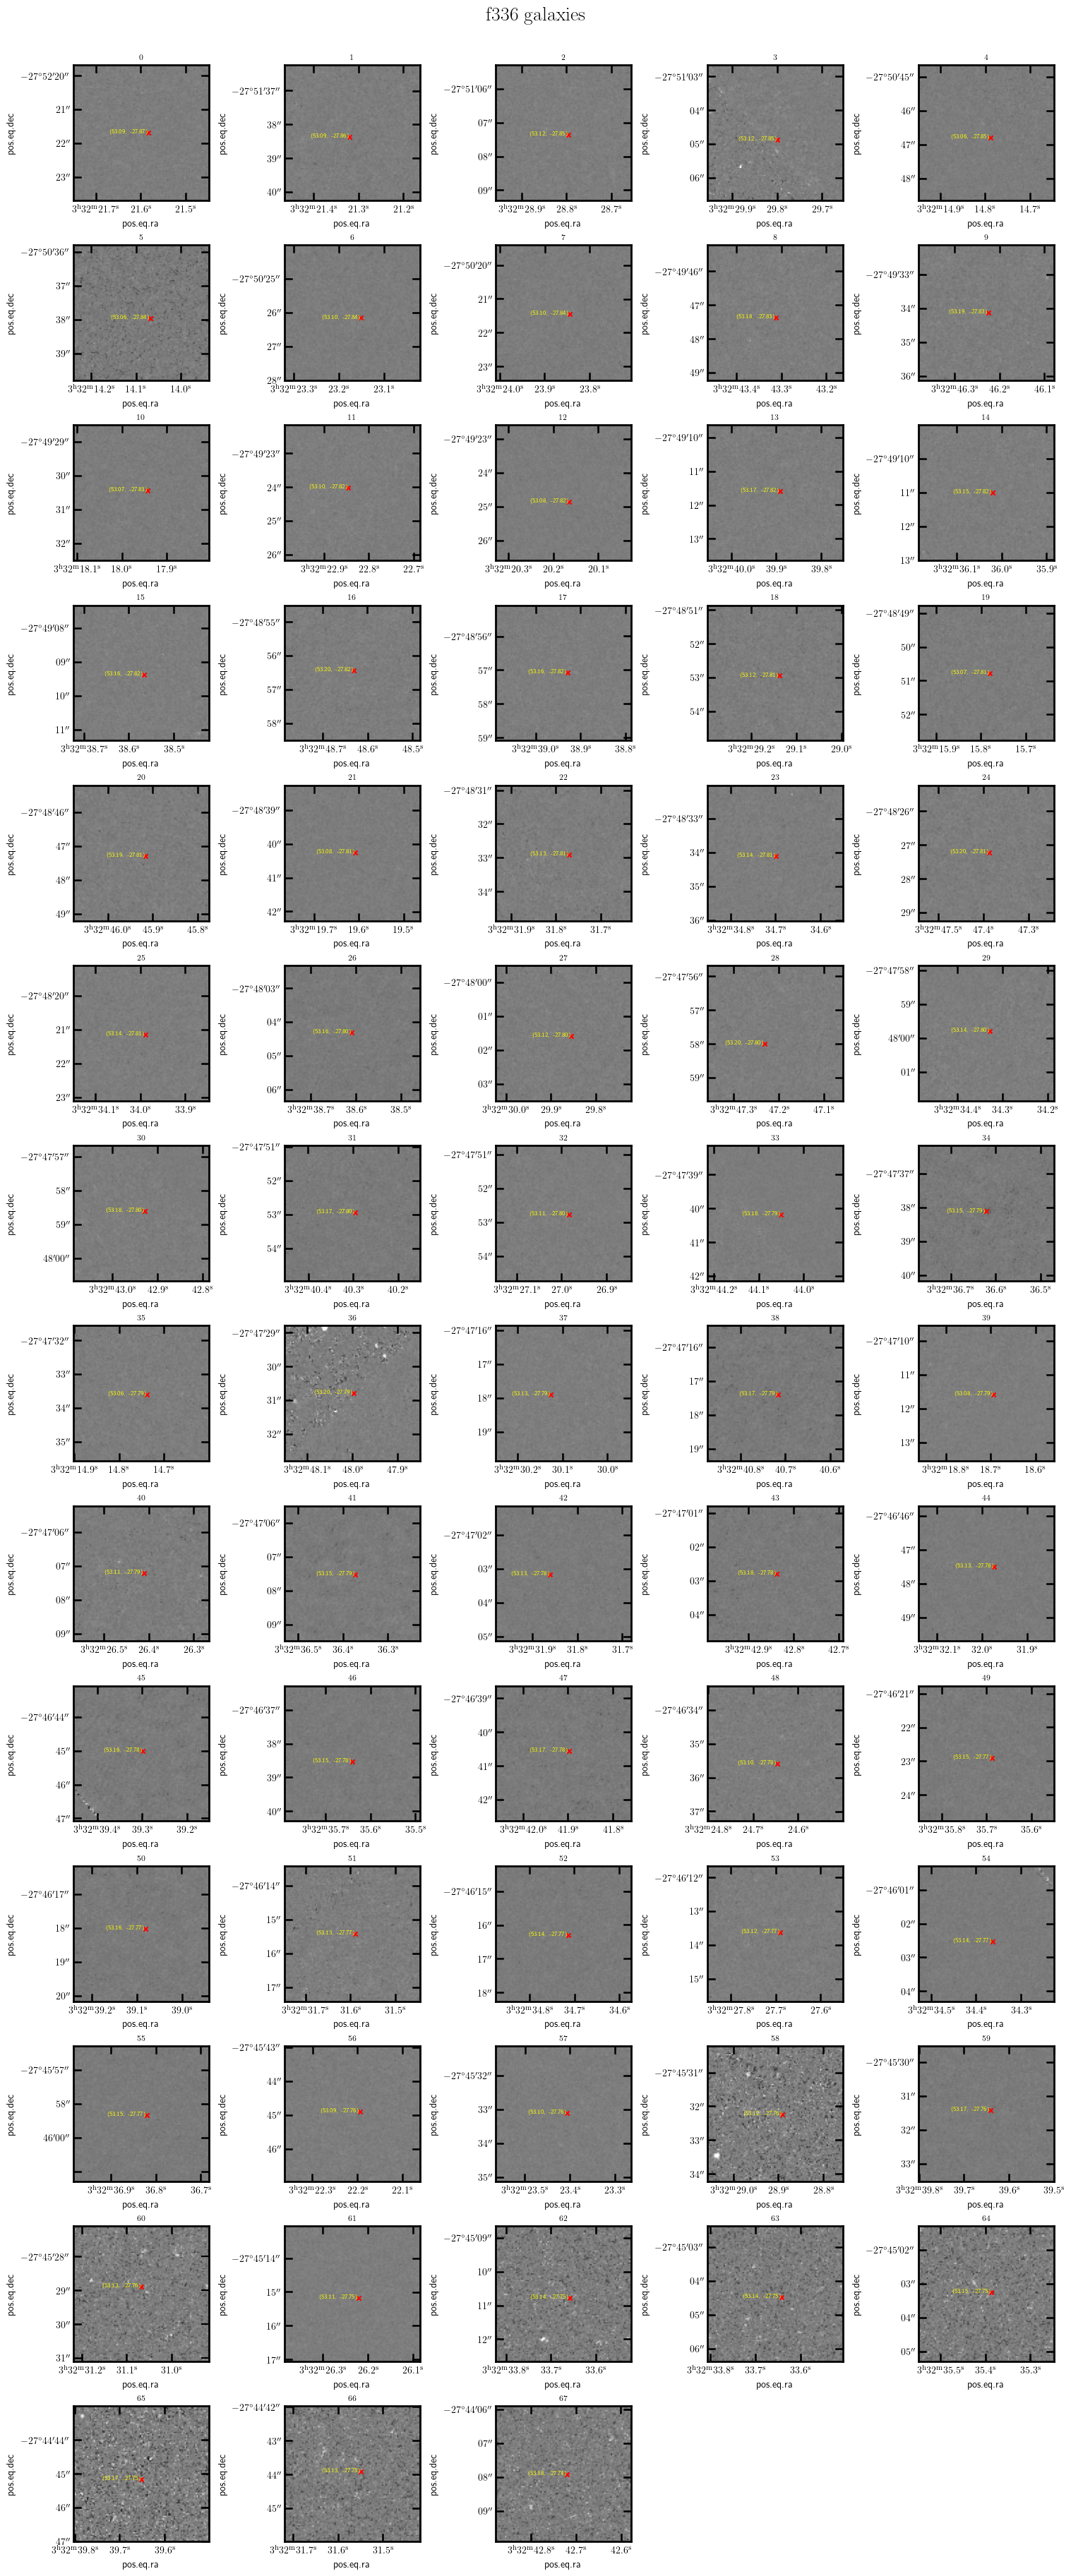

In [7]:
# Define the number of rows and columns for the grid
rows, cols = 14, 5  # Adjusted to fit 60 images

# Create the figure
fig = plt.figure(figsize=(15, 36))  # Adjusted height for better spacing
fig.suptitle(r'\rm f336 galaxies', fontsize=20, fontweight='bold', y=1.01)

# Global min and max for scaling
use_control = True
vmin, vmax = -1, 1
# Define the normalization with a threshold for linear scaling
norm = SymLogNorm(linthresh=0.1, linscale=0.1, vmin=vmin, vmax=vmax)
# Example RA/Dec values
if use_control == True:
    
    ra_list  = Control_[-4].data  # List of RA values in degrees
    dec_list = Control_[-3].data  # List of Dec values in degrees

    cropped_img_with_source_filt0_arr = Control_[4].data
    cropaped_mask                      = Control_[2].data

else:
    
    ra_list  = EELGs_[-4].data  # List of RA values in degrees
    dec_list = EELGs_[-3].data  # List of Dec values in degrees

    cropped_img_with_source_filt0_arr = EELGs_[4].data
    cropped_mask                      = EELGs_[2].data

# Iterate over images and create individual WCS subplots
for i in range(rows * cols):
    if i < len(cropped_img_with_source_filt0_arr):
        # Extract the correct WCS for this image
        if use_control == True:
            wcs = WCS(Control_[9+i].header)  # Assuming this is a list of WCS objects
        else:
            wcs = WCS(EELGs_[9+i].header)  # Assuming this is a list of WCS objects
        # Create subplot with WCS projection
        ax = fig.add_subplot(rows, cols, i+1, projection=wcs)

        # Convert RA/Dec to pixel coordinates for this specific WCS
        x_pix, y_pix = wcs.world_to_pixel_values(ra_list[i], dec_list[i])

        # Plot the image with consistent scaling
        ax.imshow(cropped_img_with_source_filt0_arr[i], 
                  origin='lower', cmap='gray', norm=norm)
        #ax.imshow(cropped_mask[i], origin='lower', alpha=0.2)
        ax.set_title(r"\rm %d" % i, fontsize=8)

        # Overlay converted pixel coordinates
        ax.scatter(x_pix, y_pix, marker='x', color='red', s=20, label="Source")

        # Annotate with RA/Dec values
        ax.annotate(f"({ra_list[i]:.2f}, {dec_list[i]:.2f})", 
                    (x_pix, y_pix), fontsize=6, color='yellow', ha='right')

        # Remove ticks
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        ax = fig.add_subplot(rows, cols, i+1)  # Empty subplot
        ax.axis('off')  # Hide unused slots

# Adjust layout to minimize space between images
plt.tight_layout(pad=0.1, h_pad=0.1, w_pad=0.1)
plt.show()



In [ ]:
# Define the number of rows and columns for the grid
rows, cols = 5, 5  # Adjusted to fit 60 images

# Create the figure
fig = plt.figure(figsize=(15, 36))  # Adjusted height for better spacing
fig.suptitle(r'\rm f814 galaxies', fontsize=20, fontweight='bold', y=1.01)

# Global min and max for scaling
use_control = False
vmin, vmax = -0.1, 0.1
# Define the normalization with a threshold for linear scaling
norm = SymLogNorm(linthresh=0.01, linscale=0.1, vmin=vmin, vmax=vmax)
# Example RA/Dec values
if use_control == True:
    
    ra_list  = Control_[-4].data  # List of RA values in degrees
    dec_list = Control_[-3].data  # List of Dec values in degrees

    cropped_img_with_source_filt0_arr = Control_[3].data
    cropped_mask                      = Control_[2].data

else:
    
    ra_list  = EELGs_[-4].data  # List of RA values in degrees
    dec_list = EELGs_[-3].data  # List of Dec values in degrees

    cropped_img_with_source_filt0_arr = EELGs_[3].data
    cropped_mask                      = EELGs_[2].data

# Iterate over images and create individual WCS subplots
for i in range(rows * cols):
    if i < len(cropped_img_with_source_filt0_arr):
        # Extract the correct WCS for this image
        if use_control == True:
            wcs = WCS(Control_[9+i].header)  # Assuming this is a list of WCS objects
        else:
            wcs = WCS(EELGs_[9+i].header)  # Assuming this is a list of WCS objects
        # Create subplot with WCS projection
        ax = fig.add_subplot(rows, cols, i+1, projection=wcs)

        # Convert RA/Dec to pixel coordinates for this specific WCS
        x_pix, y_pix = wcs.world_to_pixel_values(ra_list[i], dec_list[i])

        # Plot the image with consistent scaling
        ax.imshow(cropped_img_with_source_filt0_arr[i], 
                  origin='lower', cmap='gray', norm=norm)
        #ax.imshow(cropped_mask[i], origin='lower', alpha=0.1)
        ax.set_title(r"\rm %d" % i, fontsize=8)

        # Overlay converted pixel coordinates
        ax.scatter(x_pix, y_pix, marker='x', color='red', s=20, label="Source")

        # Annotate with RA/Dec values
        ax.annotate(f"({ra_list[i]:.2f}, {dec_list[i]:.2f})", 
                    (x_pix, y_pix), fontsize=6, color='yellow', ha='right')

        # Remove ticks
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        ax = fig.add_subplot(rows, cols, i+1)  # Empty subplot
        ax.axis('off')  # Hide unused slots

# Adjust layout to minimize space between images
plt.tight_layout(pad=0.1, h_pad=0.1, w_pad=0.1)
plt.show()


In [9]:
use_control=False
if use_control==True:
    F814_og         = Control_[0].data      
    F336_og         = Control_[1].data
    F814_sgm        = Control_[2].data      
    F814_img        = Control_[3].data
    F336_img        = Control_[4].data
    F814_background = Control_[5].data   
    F336_background = Control_[6].data   
    F814_weights    = Control_[7].data
    F336_weights    = Control_[8].data
    zspec           = Control_[-1].data
else:
    F814_og         = EELGs_[0].data      
    F336_og         = EELGs_[1].data
    F814_sgm        = EELGs_[2].data      
    F814_img        = EELGs_[3].data
    F336_img        = EELGs_[4].data
    F814_background = EELGs_[5].data   
    F336_background = EELGs_[6].data   
    F814_weights    = EELGs_[7].data
    F336_weights    = EELGs_[8].data
    zspec           = EELGs_[-1].data

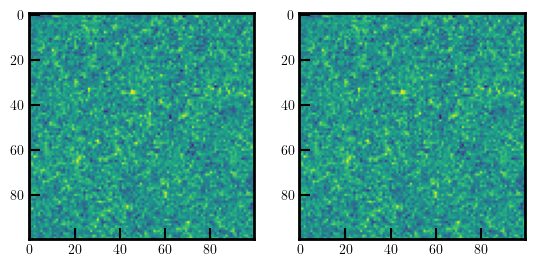

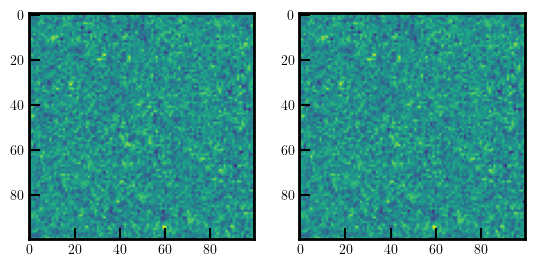

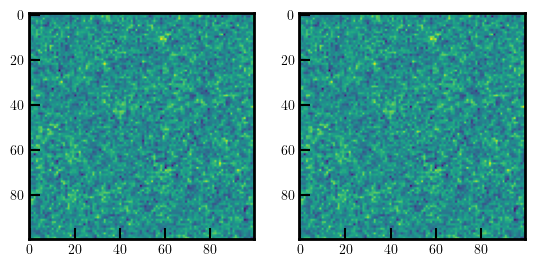

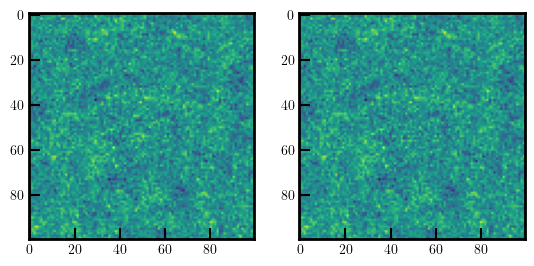

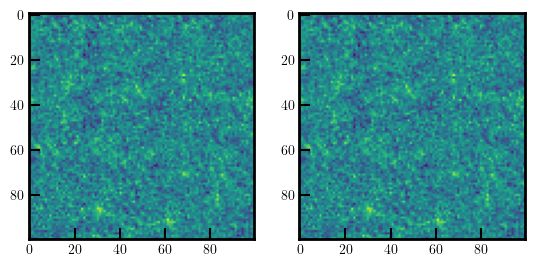

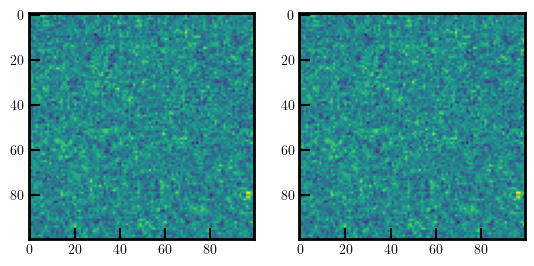

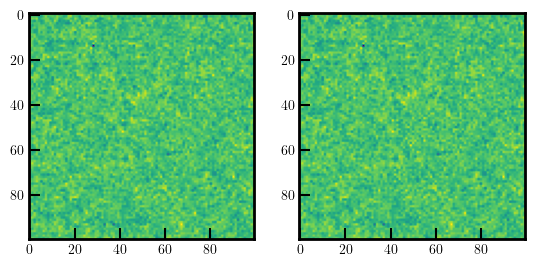

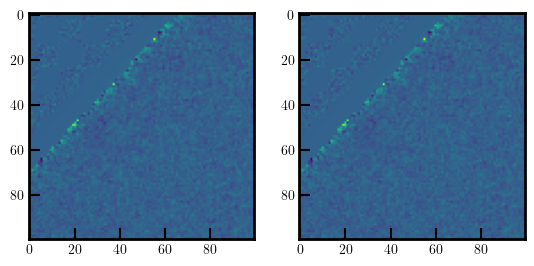

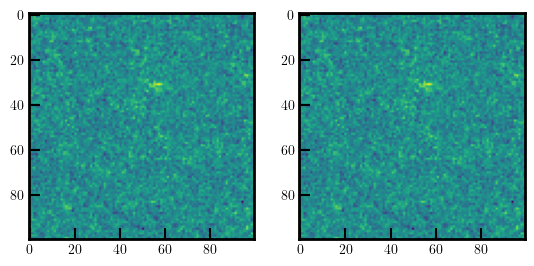

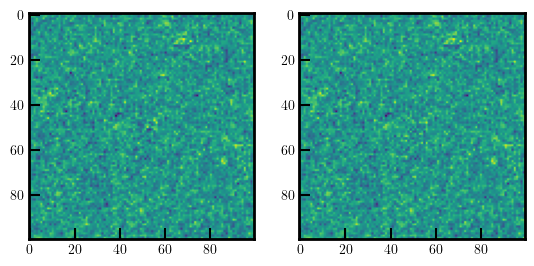

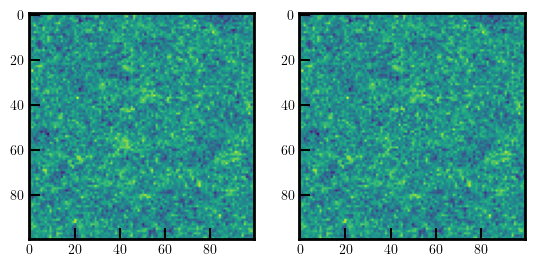

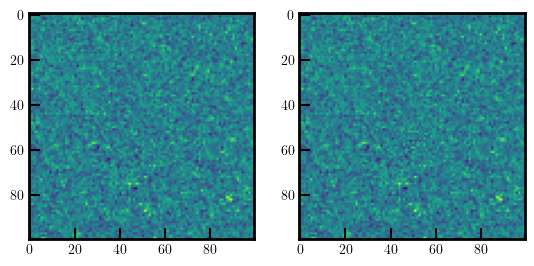

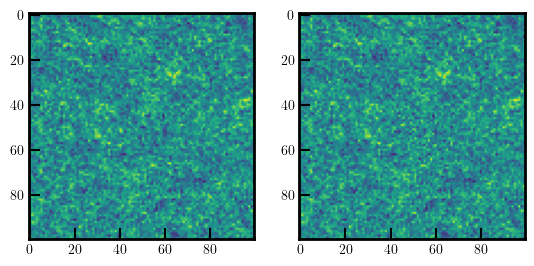

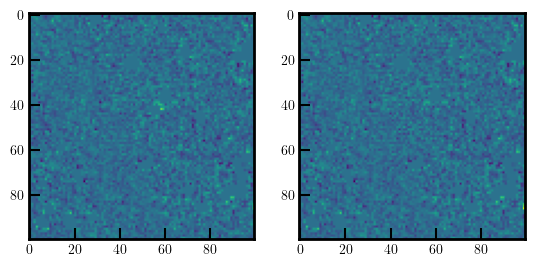

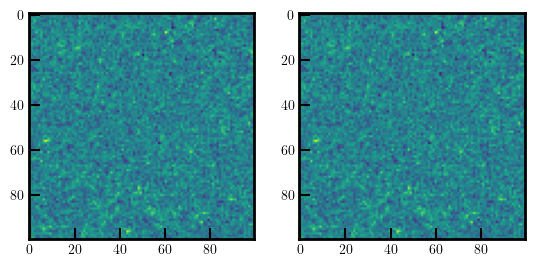

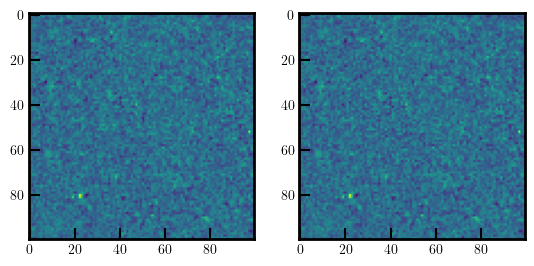

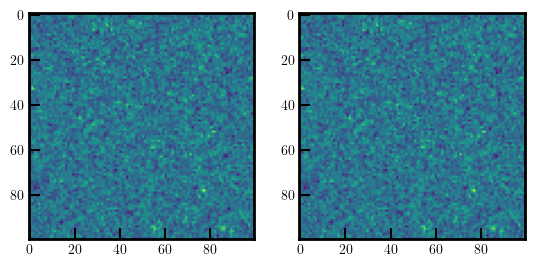

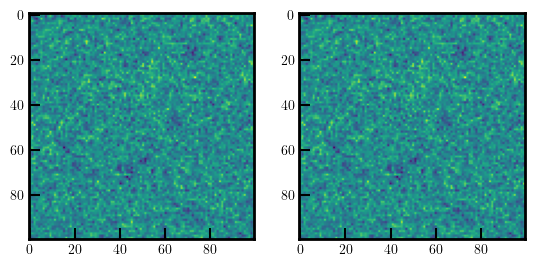

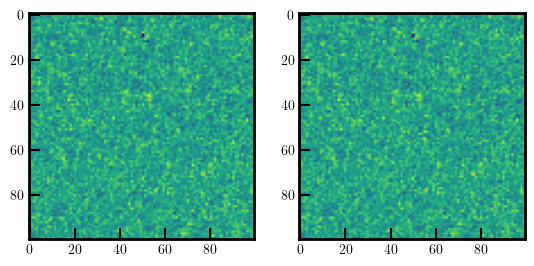

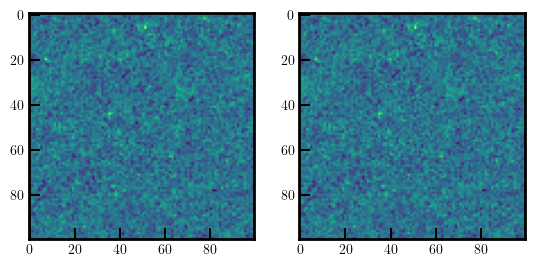

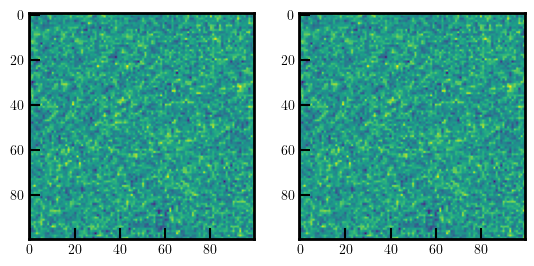

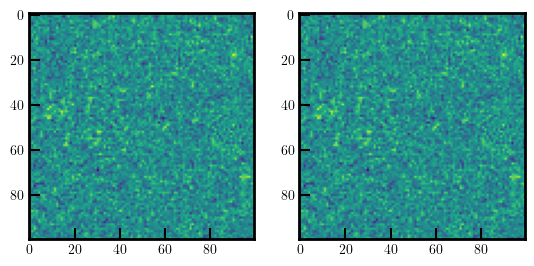

In [10]:
for i in range(F336_background.shape[0]):
    plt.subplot(121)
    plt.imshow(F336_img[i])
    plt.subplot(122)
    plt.imshow(F336_background[i])
    plt.show()

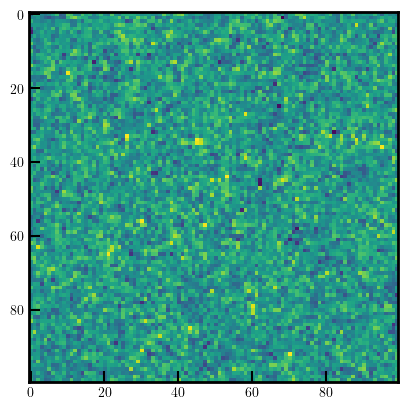

In [11]:
plt.imshow(F336_og[0])

In [ ]:
## final stacking
def get_wtd_mean(data, wts):
    wtd_mean = np.nansum(data*wts, axis=0)/ np.nansum(wts, axis=0)
    return wtd_mean

def inverse_variance_weighted_mean(images, noise):
    """
    Compute the inverse variance-weighted mean of a stack of images.

    Parameters:
    - images: np.ndarray, shape (25, 100, 100)
      The stack of images.
    - noise: np.ndarray, shape (25, 100, 100)
      The corresponding noise values (standard deviation) for each image.

    Returns:
    - weighted_mean: np.ndarray, shape (100, 100)
      The inverse variance-weighted mean of the input images.
    """
    # Calculate the inverse variance (1 / noise^2)
    inverse_variance = 1. / (noise**2)
    
    
    # Compute the numerator: sum(image / noise^2)
    numerator = np.nansum(images * inverse_variance, axis=0)
    
    # Compute the denominator: sum(1 / noise^2)
    denominator = np.nansum(inverse_variance, axis=0)
    
    # Avoid division by zero
    #denominator[denominator == 0] = np.nan
    
    # Calculate the weighted mean
    weighted_mean = numerator / denominator
    
    # Handle potential NaN values
    #weighted_mean = np.nan_to_num(weighted_mean)
    
    return weighted_mean



In [ ]:
def inverse_variance_weighted_mean2(images, noise):
    """
    Compute the inverse variance-weighted mean of a stack of images.

    Parameters:
    - images: np.ndarray, shape (25, 100, 100)
      The stack of images.
    - noise: np.ndarray, shape (25, 100, 100)
      The corresponding noise values (standard deviation) for each image.

    Returns:
    - weighted_mean: np.ndarray, shape (100, 100)
      The inverse variance-weighted mean of the input images.
    """
    # Calculate the inverse variance (1 / noise^2)
    noise = noise.reshape(noise.shape[0], -1)**2
    
    inverse_variance = np.nanstd((1. / (noise)), axis = -1)
    inverse_variance = np.expand_dims(inverse_variance, axis=1)
    inverse_variance = np.expand_dims(inverse_variance, axis=1)
    
    # Compute the numerator: sum(image / noise^2)
    numerator = np.nansum(images * inverse_variance, axis=0)
    
    # Compute the denominator: sum(1 / noise^2)
    denominator = np.nansum(inverse_variance, axis=0)
    
    # Avoid division by zero
    #denominator[denominator == 0] = np.nan
    
    # Calculate the weighted mean
    weighted_mean = numerator / denominator
    
    # Handle potential NaN values
    #weighted_mean = np.nan_to_num(weighted_mean)
    return weighted_mean


In [ ]:
F814_wtd_mean          = get_wtd_mean                   (data  =F814_img,   wts=F814_weights) # using weight images
F814_inv_var_wtd_mean  = inverse_variance_weighted_mean (images=F814_img, noise=1/F814_weights)
F814_inv_var_wtd_mean2 = inverse_variance_weighted_mean2(images=F814_img, noise=1/F814_weights)


F814_bg_wtd_mean          = get_wtd_mean                   (data  =F814_img,   wts=F814_background) # using weight images
F814_bg_inv_var_wtd_mean  = inverse_variance_weighted_mean (images=F814_img, noise=1/F814_background)
F814_bg_inv_var_wtd_mean2 = inverse_variance_weighted_mean2(images=F814_img, noise=1/F814_background)



F336_wtd_mean          = get_wtd_mean                   (data  =F336_img,   wts=F336_weights) # using weight images
F336_inv_var_wtd_mean  = inverse_variance_weighted_mean (images=F336_img, noise=1/F336_weights)
F336_inv_var_wtd_mean2 = inverse_variance_weighted_mean2(images=F336_img, noise=1/F336_weights)


F336_bg_wtd_mean          = get_wtd_mean                   (data  =F336_img,   wts=F336_background) # using weight images
F336_bg_inv_var_wtd_mean  = inverse_variance_weighted_mean (images=F336_img, noise=1/F336_background)
F336_bg_inv_var_wtd_mean2 = inverse_variance_weighted_mean2(images=F336_img, noise=1/F336_background)

In [ ]:
plt.imshow(F814_img[0])

In [ ]:
plt.imshow(F814_weights[0])
plt.colorbar()

In [ ]:
plt.imshow(F814_background[0])
plt.colorbar()

In [ ]:
plt.plot(np.nanmean(F814_weights[0], axis=0))

In [ ]:
vmin = -0.1
vmax = 0.1
norm = SymLogNorm(linthresh=0.01, linscale=1.0, vmin=vmin, vmax=vmax)


fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
fig.suptitle("Comparison of Weighted Means: eelgs sample F814 (using fits weights)", fontsize=16)
# Plot the three images
im1 = axs[0].imshow(F814_wtd_mean, norm=norm, origin='lower', cmap='Greys_r')
axs[0].set_title('wtd mean',)

im2 = axs[1].imshow(F814_inv_var_wtd_mean, norm=norm, origin='lower', cmap='Greys_r')
axs[1].set_title('inv var wtd mean (using all pixels)', )

im3 = axs[2].imshow(F814_inv_var_wtd_mean2, norm=norm, origin='lower', cmap='Greys_r')
axs[2].set_title("inv var wtd mean (using single value (Nick's suggestion)", )

# Add a **horizontal colorbar** below all subplots
cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Flux-density (10nJy)')

# Adjust layout to leave space for colorbar
plt.tight_layout(rect=[0, 0.12, 1, 1])  # Leaves space at the bottom for the colorbar
plt.savefig('eelgs_sample_wtd_mean_compare_814.jpg', dpi=220)
#plt.show()

In [ ]:
vmin = -1
vmax = 1
norm = SymLogNorm(linthresh=0.1, linscale=1.0, vmin=vmin, vmax=vmax)

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
fig.suptitle("Comparison of Weighted Means: eelgs sample F336 (using fits weights)", fontsize=16)
# Plot the three images
im1 = axs[0].imshow(F336_wtd_mean, norm=norm, origin='lower', cmap='Greys_r')
axs[0].set_title('wtd mean',)

im2 = axs[1].imshow(F336_inv_var_wtd_mean, norm=norm, origin='lower', cmap='Greys_r')
axs[1].set_title('inv var wtd mean (using all pixels)', )

im3 = axs[2].imshow(F336_inv_var_wtd_mean2, norm=norm, origin='lower', cmap='Greys_r')
axs[2].set_title("inv var wtd mean (using single value (Nick's suggestion)", )

# Add a **horizontal colorbar** below all subplots
cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Flux-density (10nJy)')

# Adjust layout to leave space for colorbar
plt.tight_layout(rect=[0, 0.12, 1, 1])  # Leaves space at the bottom for the colorbar
plt.savefig('eelgs_sample_wtd_mean_compare_336.jpg', dpi=220)
#plt.show()

In [ ]:
#vmin = -0.1
#vmax = 0.1
#norm = SymLogNorm(linthresh=0.01, linscale=1.0, vmin=vmin, vmax=vmax)

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
fig.suptitle("Comparison of Weighted Means: eelgs sample F814 (using background weights)", fontsize=16)
# Plot the three images
im1 = axs[0].imshow(F814_bg_wtd_mean, norm=norm, origin='lower', cmap='Greys_r')
axs[0].set_title('wtd mean',)

im2 = axs[1].imshow(F814_bg_inv_var_wtd_mean, norm=norm, origin='lower', cmap='Greys_r')
axs[1].set_title('inv var wtd mean (using all pixels)', )

im3 = axs[2].imshow(F814_bg_inv_var_wtd_mean2, norm=norm, origin='lower', cmap='Greys_r')
axs[2].set_title("inv var wtd mean (using single value (Nick's suggestion)", )

# Add a **horizontal colorbar** below all subplots
cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Flux-density (10nJy)')

# Adjust layout to leave space for colorbar
plt.tight_layout(rect=[0, 0.12, 1, 1])  # Leaves space at the bottom for the colorbar
plt.savefig('eelgs_sample_bg_wtd_mean_compare_814.jpg', dpi=220)
#plt.show()

In [ ]:
vmin = -1
vmax = 1
norm = SymLogNorm(linthresh=1, linscale=1, vmin=vmin, vmax=vmax)


fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
fig.suptitle("Comparison of Weighted Means: eelgs sample F336 (using background weights)", fontsize=16)
# Plot the three images
im1 = axs[0].imshow(F336_bg_wtd_mean, norm=norm, origin='lower', cmap='Greys_r')
axs[0].set_title('wtd mean',)

im2 = axs[1].imshow(F336_bg_inv_var_wtd_mean, norm=norm, origin='lower', cmap='Greys_r')
axs[1].set_title('inv var wtd mean (using all pixels)', )

im3 = axs[2].imshow(F336_bg_inv_var_wtd_mean2, norm=norm, origin='lower', cmap='Greys_r')
axs[2].set_title("inv var wtd mean (using single value (Nick's suggestion)", )

# Add a **horizontal colorbar** below all subplots
cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Flux-density (10nJy)')

# Adjust layout to leave space for colorbar
plt.tight_layout(rect=[0, 0.12, 1, 1])  # Leaves space at the bottom for the colorbar
plt.savefig('eelgs_sample_bg_wtd_mean_compare_336.jpg', dpi=220)
#plt.show()

In [ ]:
F336_smoothed_image    = gaussian_filter(F336_img    , sigma=1) # smoothing
F336_weights_image     = gaussian_filter(F336_weights, sigma=1)
F336_bg_weights_image  = gaussian_filter(F336_background, sigma=1)

F336_wtd_mean          = get_wtd_mean                   (data  =F336_smoothed_image,   wts=F336_weights_image)
F336_inv_var_wtd_mean  = inverse_variance_weighted_mean (images=F336_smoothed_image, noise=F336_weights_image)
F336_inv_var_wtd_mean2 = inverse_variance_weighted_mean2(images=F336_smoothed_image, noise=F336_weights_image)

F336_bg_wtd_mean          = get_wtd_mean                   (data  =F336_smoothed_image,   wts=F336_bg_weights_image)
F336_bg_inv_var_wtd_mean  = inverse_variance_weighted_mean (images=F336_smoothed_image, noise=F336_bg_weights_image)
F336_bg_inv_var_wtd_mean2 = inverse_variance_weighted_mean2(images=F336_smoothed_image, noise=F336_bg_weights_image)



In [ ]:
vmin = -1
vmax = 1
norm = SymLogNorm(linthresh=0.1, linscale=1.0, vmin=vmin, vmax=vmax)


fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
fig.suptitle("Comparison of Weighted Means: eelgs sample F336 1-sigma smoothed (using background weights)", fontsize=16)
# Plot the three images
im1 = axs[0].imshow(F336_bg_wtd_mean, norm=norm, origin='lower', cmap='Greys_r')
axs[0].set_title('wtd mean',)

im2 = axs[1].imshow(F336_bg_inv_var_wtd_mean, norm=norm, origin='lower', cmap='Greys_r')
axs[1].set_title('inv var wtd mean (using all pixels)', )

im3 = axs[2].imshow(F336_bg_inv_var_wtd_mean2, norm=norm, origin='lower', cmap='Greys_r')
axs[2].set_title("inv var wtd mean (using single value (Nick's suggestion)", )

# Add a **horizontal colorbar** below all subplots
cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Flux-density (10nJy)')

# Adjust layout to leave space for colorbar
plt.tight_layout(rect=[0, 0.12, 1, 1])  # Leaves space at the bottom for the colorbar
plt.savefig('eelgs_sample_bg_wtd_smooth_mean_compare_336.jpg', dpi=220)
#plt.show()

In [ ]:
vmin = -1
vmax = 1
norm = SymLogNorm(linthresh=0.1, linscale=1.0, vmin=vmin, vmax=vmax)


fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
fig.suptitle("Comparison of Weighted Means: eelgs sample F336 1-sigma smoothed (using fits weights)", fontsize=16)
# Plot the three images
im1 = axs[0].imshow(F336_wtd_mean, norm=norm, origin='lower', cmap='Greys_r')
axs[0].set_title('wtd mean',)

im2 = axs[1].imshow(F336_inv_var_wtd_mean, norm=norm, origin='lower', cmap='Greys_r')
axs[1].set_title('inv var wtd mean (using all pixels)', )

im3 = axs[2].imshow(F336_inv_var_wtd_mean2, norm=norm, origin='lower', cmap='Greys_r')
axs[2].set_title("inv var wtd mean (using single value (Nick's suggestion)", )

# Add a **horizontal colorbar** below all subplots
cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Flux-density (10nJy)')

# Adjust layout to leave space for colorbar
plt.tight_layout(rect=[0, 0.12, 1, 1])  # Leaves space at the bottom for the colorbar
plt.savefig('eelgs_sample_wtd_smooth_mean_compare_336.jpg', dpi=220)
#plt.show()

In [ ]:
for i in range(22):
    plt.subplot(121)
    plt.imshow(F336_og[i], cmap='Greys_r')
    plt.imshow(F814_sgm[i], alpha=0.5, )
    plt.subplot(122)
    plt.imshow(F336_img[i], cmap='Greys_r' )
    
    plt.show()

In [ ]:
F336_img_masked = np.ma.masked_array(F336_img,   mask=~F814_sgm.astype(bool))
F336_imgbg_masked = np.ma.masked_array(F336_img, mask= F814_sgm.astype(bool) )

In [ ]:
def apply_union_mask(masked_array):
    """
    Compute the union mask from all datasets and modify individual masks by setting mismatched 
    pixels to NaN in the data.
    
    Parameters:
    masked_array (np.ma.MaskedArray): Input masked array of shape (N, H, W).
    
    Returns:
    np.ndarray: Modified data array with NaNs where individual masks do not match the union mask.
    """
    if not isinstance(masked_array, np.ma.MaskedArray):
        raise ValueError("Input must be a numpy masked array")

    # Extract the mask (True means masked, False means unmasked)
    mask_array = masked_array.mask  # Shape (N, H, W)

    # Compute the union mask (product ensures a pixel is masked if masked in any individual mask)
    union_mask = np.prod(~mask_array, axis=0, dtype=bool)  # Shape (H, W), boolean mask

    # Create a copy of the data and fill mismatched pixels with NaN
    modified_data = masked_array.data.copy()

    for i in range(masked_array.shape[0]):
        mismatched_mask = mask_array[i] != union_mask  # Pixels where masks differ
        modified_data[i][mismatched_mask] = np.nan  # Set NaN where mismatch occurs

    return modified_data





In [ ]:
modified_F814_img = np.ma.masked_array(data=F814_img, mask=~F814_sgm.astype(bool))

In [ ]:
for i in range(22):
    print(i)
    plt.imshow(modified_F814_img[i])
    plt.show()

In [ ]:
plt.imshow(np.nanmean(modified_F814_img, axis=0))

In [ ]:
plt.imshow(np.ma.masked_values(np.nansum(F814_sgm, axis=0), value=0))
plt.colorbar(label='pixels having signal')

In [ ]:
F814_img.shape

In [ ]:
wts = np.expand_dims(np.nanstd(F814_background.reshape(F814_img.shape[0], -1), axis=-1), axis=1)
wts = np.expand_dims(wts, axis=1)

In [ ]:
wts.shape

In [ ]:
plt.imshow(np.nansum(wts*F814_img, axis=0)/np.nansum(wts), norm=norm, origin='lower')

In [ ]:
wts = np.expand_dims(np.nanstd(F336_img.reshape(F336_background.shape[0], -1), axis=-1), axis=1)
wts = np.expand_dims(wts, axis=1)
plt.imshow(np.nansum(wts*F336_img, axis=0)/np.nansum(wts), norm=norm)

In [ ]:
fluxes_shifted814, avg_flux814 = shift_flux_to_common_redshift(fluxes=F814_img, redshifts=zspec, z_ref=3.08, alpha=2)
fluxes_shifted336, avg_flux336 = shift_flux_to_common_redshift(fluxes=F336_img, redshifts=zspec, z_ref=3.08, alpha=2)

plt.imshow(np.nanmean(fluxes_shifted814, axis=0), norm=norm, origin='lower')


In [ ]:
plt.imshow(np.nanmean(fluxes_shifted336, axis=0), vmin=-0.1, vmax=0.1, origin='lower')